## Factor analysis

In [157]:
# calculate features
from rdkit import Chem
from analysis.factor.descriptors import all_descriptors
index_filepath = os.path.join(base_dir, 'dataset/bitter_sweet_nonbitter/secondary_bsn.csv')
df = pd.read_csv(index_filepath, header=0, sep=',')
descriptor_names = []
with open(os.path.join(base_dir,'analysis/factor/descriptors.txt')) as f:
    lines = f.readlines()
    for line in lines:
        descriptor_names.append(line.strip())
features = []
for i,smiles in enumerate(list(df['smiles'])):
    mol = Chem.MolFromSmiles(smiles)
    features.append(all_descriptors(mol))
features=np.array(features)
df_feature = pd.DataFrame(features)
df_feature.to_csv(os.path.join(base_dir,'analysis/factor/features.csv'),sep=',',index=False,header=descriptor_names)
print(df_feature.shape)

(2779, 195)


In [209]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
# descriptor_names = []
# with open(os.path.join(base_dir,'analysis/factor/descriptors.txt'),'r') as f:
#     lines = f.readlines()
#     for line in lines:
#         descriptor_names.append(line.strip())
df_idx = pd.read_csv(os.path.join(base_dir, 'dataset/bitter_sweet_nonbitter/secondary_bsn.csv'), header=0, sep=',')
# df_idx.insert(0, 'index', range(len(df)), allow_duplicates=False)
bitter_idx = list(df_idx.query(' Taste=="Bitter" ')['index'])
sweet_idx = list(df_idx.query(' Taste=="Sweet" ')['index'])
nonbitter_idx = list(df_idx.query(' Taste=="Non-bitter-Sweet" | Taste=="Sweet" ')['index'])
df_ft = pd.read_csv(os.path.join(base_dir,'analysis/factor/features.csv'),header=0,sep=',')
descriptor_names = list(df_ft)

zero_nums = list((df_ft == 0).astype(int).sum(axis=0))
zero_features = []
for i,zero_num in enumerate(zero_nums):
    if zero_num > 900:
        zero_features.append(descriptor_names[i])

df_ft = df_ft.drop(zero_features,axis=1,inplace=False)
df = pd.concat([df_idx, df_ft], axis=1)
df_bs = df.query(' Taste=="Bitter" | Taste=="Sweet" ')
df_bn = df.replace('Sweet','Non-bitter-Sweet')
print(df_bn)
bs_ft = df_bs.iloc[:,3:]
bn_ft = df_bn.iloc[:,3:]
# print()
print(len(bs_ft.columns))
print(bs_ft.shape)
print(bn_ft.shape)
 

      index                                             smiles  \
0         0  CC1=CC(=O)C2=C(C)CC[C@@H]3[C@H](OC(=O)[C@@H]3C...   
1         1  C[C@@H]1O[C@@H](O[C@@H]2[C@@H](O)[C@H](OCCc3cc...   
2         2  COc1cc(-c2c(C)cc(O)cc2O[C@@H]2O[C@H](CO)[C@@H]...   
3         3  COC(=O)[C@@]12OC[C@@]34C(C[C@H]5C(C)=C(O)C(=O)...   
4         4  COC(=O)[C@]12OC[C@@]34[C@H]1[C@@H](OC(=O)/C=C(...   
...     ...                                                ...   
2774   2774                           CC(C)CCOC(=O)CCC1=CC=CO1   
2775   2775                       CCCC(=O)OC(C)(C)C1CCC(=CC1)C   
2776   2776                                     CCCCCC=CC(=O)O   
2777   2777                                     CCOC(=O)CC(C)S   
2778   2778                                   CC(C)CC(C(=O)C)O   

                 Taste    MolWt  ExactMolWt  FpDensityMorgan1  \
0               Bitter  246.306  246.125594          1.277778   
1               Bitter  624.592  624.205420          0.818182   
2           

843524.0696526434 0.0
0.9234788328976629


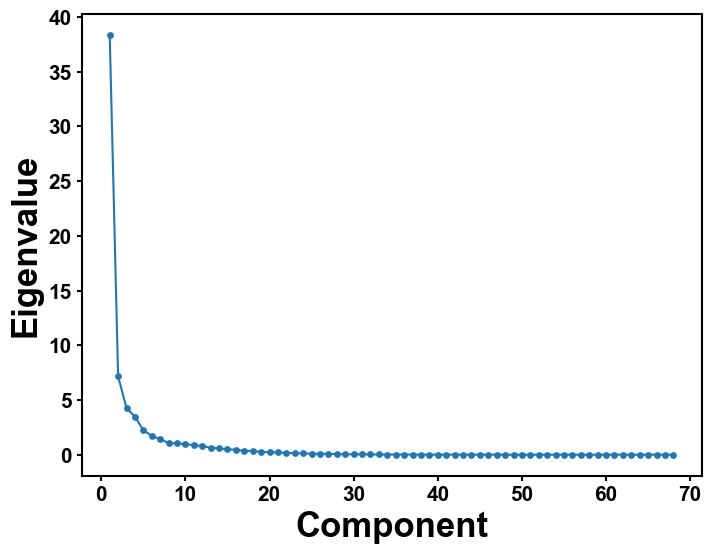

(array([25.0749535 , 18.56670929,  4.52441915,  4.1778276 ]), array([0.36874932, 0.27303984, 0.06653558, 0.06143864]), array([0.36874932, 0.64178916, 0.70832473, 0.76976338]))


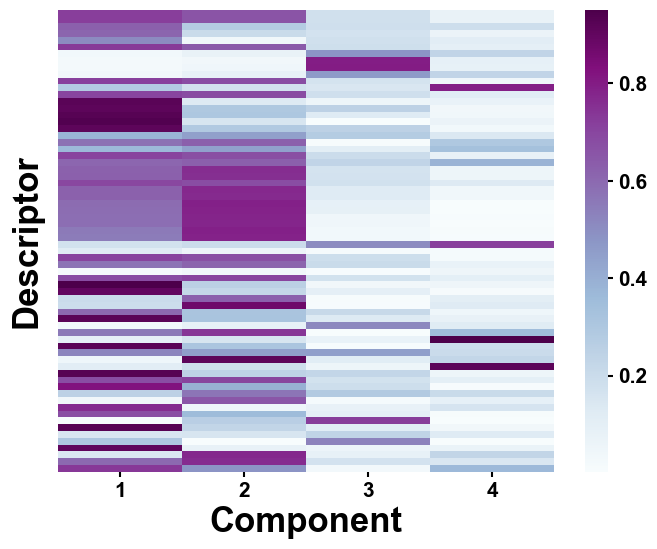

['D9' 'D14' 'D15' 'D16' 'D17' 'D18' 'D41' 'D42' 'D44' 'D46' 'D49' 'D50'
 'D52' 'D53' 'D54' 'D56' 'D62' 'D65' 'D9']


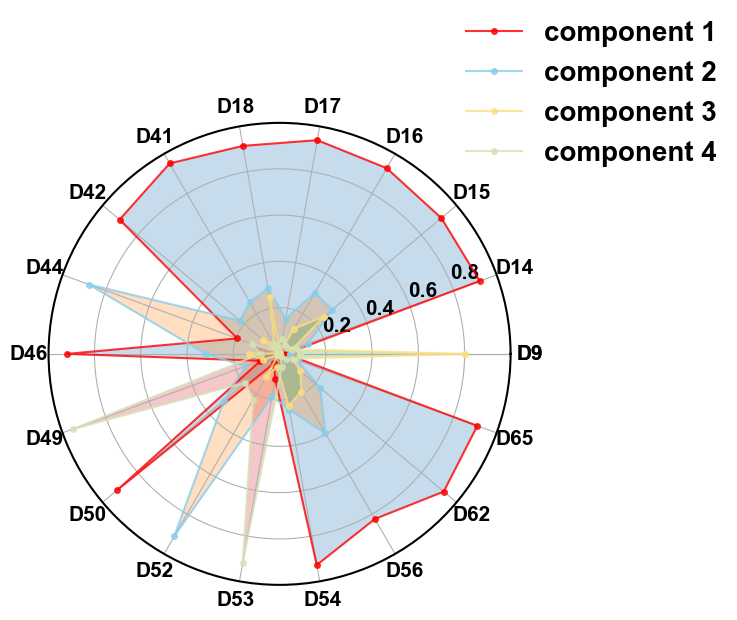

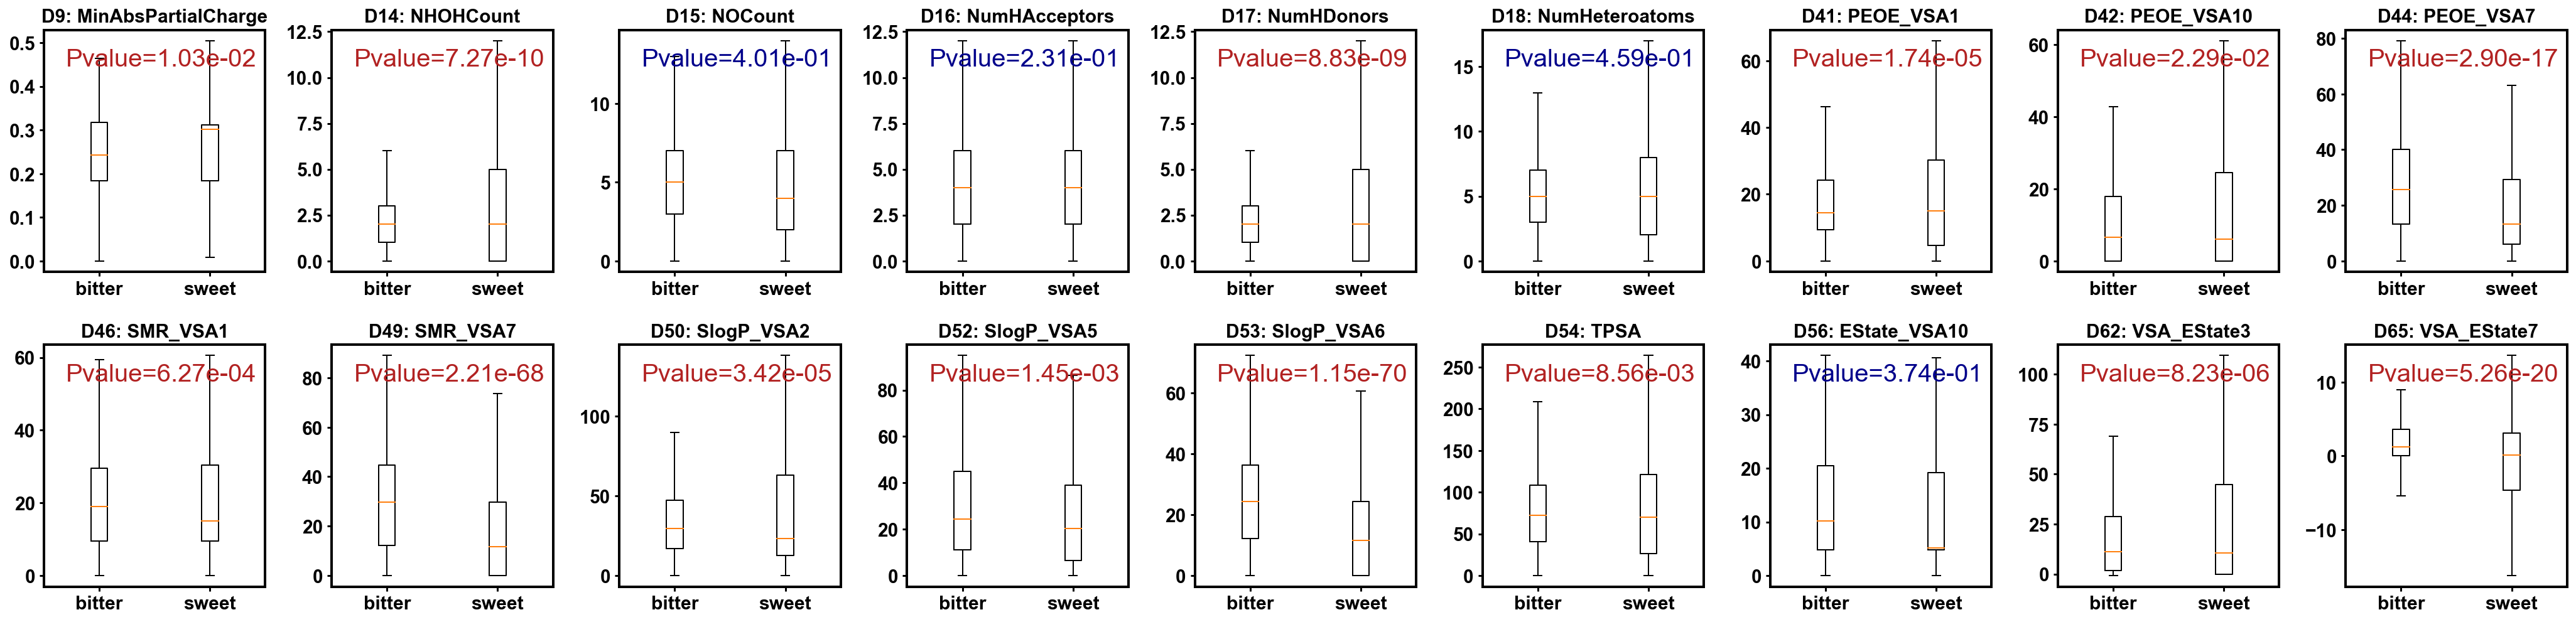

In [214]:
# bitter-sweet
plt.rc('xtick', labelsize= 15)
plt.rc('ytick', labelsize= 15) 
plt.rc('font',weight='black')
plt.rc('xtick.major',width=1.5)
plt.rc('ytick.major',width=1.5)
plt.rc('axes',labelweight='bold',labelsize=25, titlesize=17, titleweight='bold',linewidth=1.5)

def ev_plt(df):
    chi_square_value, p_value = calculate_bartlett_sphericity(df)
    print(chi_square_value, p_value)
    kmo_all,kmo_model=calculate_kmo(df)
    print(kmo_model)
    fa = FactorAnalyzer(df.shape[1],rotation=None)
    fa.fit(df)
    ev,v=fa.get_eigenvalues()
    plt.figure(figsize=(8,6))
    plt.scatter(range(1, df.shape[1] + 1), ev,s=15)
    plt.plot(range(1, df.shape[1] + 1), ev,markersize= 10)
    plt.xlabel("Component")
    plt.ylabel("Eigenvalue")
    plt.show()
    plt.savefig(os.path.join(base_dir,'analysis/factor/bs_brokenstone.png'))
    plt.close()

def heatmap_plt(df,num_factor):
    fa = FactorAnalyzer(num_factor,rotation="varimax")
    fa.fit(df)
    fa.get_communalities() #variable common degree
    fa.get_factor_variance() #variance, ratia varian, cumulative variance
    print(fa.get_factor_variance())
    fa.get_eigenvalues() #factor relative matrix,feature value
    df_loading = pd.DataFrame(np.abs(fa.loadings_),index=df.columns)
    df_loading.columns = [str(i) for i in range(1,num_factor+1)]
    ylabels= np.arange(1,69,1)
    plt.figure(figsize=(8,6))
    ax = sns.heatmap(df_loading, annot=False, cmap="BuPu",yticklabels=ylabels)
    ax.set(yticklabels=[])  # remove the tick labels
    ax.tick_params(left=False)
    ax.yaxis.set_tick_params(labelsize=3.5)
    plt.ylabel("Descriptor")
    plt.xlabel("Component")
    plt.show()
    plt.savefig(os.path.join(base_dir,'analysis/factor/bs_heatmap.png'))
    plt.close()
    df_loading.insert(0, 'index', range(len(df_loading)))
    df_loading = df_loading[(df_loading["1"] > 0.8)|(df_loading["2"] > 0.8)|(df_loading["3"] > 0.8)|(df_loading["4"] > 0.8)]
    return df_loading

def radar_plt(df):
    color_list = ['r','skyblue','#ffde7d','#D3E2B7']
    # legend_font = {'family': 'Arial','style': 'normal','size': 9,'weight': 'semibold',}
    values_ls = []
    for i in range(1,df.shape[1]):
        values_ls.append(list(df[str(i)]))
    feature = [f"D{i+1}" for i in list(df['index'])]
    angles=np.linspace(0, 2*np.pi,len(feature), endpoint=False)
    angles=np.concatenate((angles,[angles[0]]))
    feature = np.concatenate((feature,[feature[0]]))
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111,polar=True)
    for i,values in enumerate(values_ls):
        values=np.concatenate((values,[values[0]]))
        ax.plot(angles, values, 'o-', markersize= 4,linewidth=1.5,label='component {}'.format(i+1),c=color_list[i],alpha=0.8)
        ax.fill(angles, values, alpha=0.25)
        ax.set_thetagrids(angles * 180/np.pi, feature)
    ax.legend(bbox_to_anchor=(0.85, 0.85),frameon=False,fontsize=20)
    ax.grid(True)
    plt.savefig(os.path.join(base_dir,'analysis/factor/radar.png'))
    return feature

ev_plt(bs_ft)
df_loading = heatmap_plt(bs_ft,4)
feature = radar_plt(df_loading)

print(feature)
ttest_feats = df_loading.index.values
df_bs_ft = df_ft[ttest_feats]
bs_bitters_descriptors = np.array(df_bs_ft)[bitter_idx].T
bs_sweets_descriptors = np.array(df_bs_ft)[sweet_idx].T
bs_nonbitters_descriptors = np.array(df_bs_ft)[nonbitter_idx].T

def plot_bibox(A,B,labelA,labelB,title):
    pv = stats.ttest_ind(A,B,equal_var=True)
    if pv.pvalue < 0.05:
        color="#B22222"
    else:
        color="#00008B"
    plt.boxplot([A, B],
                showfliers=False,
                meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
                flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10},
                labels=[labelA,labelB])
    plt.title(title, fontweight="bold",fontsize = 15)     
    plt.text(0.1,0.85,"Pvalue={:.2e}".format(pv.pvalue),
             fontsize=20,
             fontweight="medium",
             color=color,
             transform=ax.transAxes)

font = {'family': 'Arial', 'size': 15, 'weight':'bold'}
err_attr = {"elinewidth":2, "ecolor":"black", "capsize":3}
plt.rc('font', **font)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('axes',labelweight='bold', titleweight='bold',linewidth=2.0)
plt.figure(figsize=(36,8), dpi=144)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3,hspace=0.3)
for i in range(18):
    ax=plt.subplot(2,9,i+1)
    plot_bibox(bs_bitters_descriptors[i],bs_sweets_descriptors[i],"bitter","sweet",'{}: {}'.format(feature[i],ttest_feats[i]))
plt.savefig(os.path.join(base_dir,'analysis/factor/ttest.png'),bbox_inches="tight")
plt.show()
plt.close()


884451.1163528825 0.0
0.9208616719702774


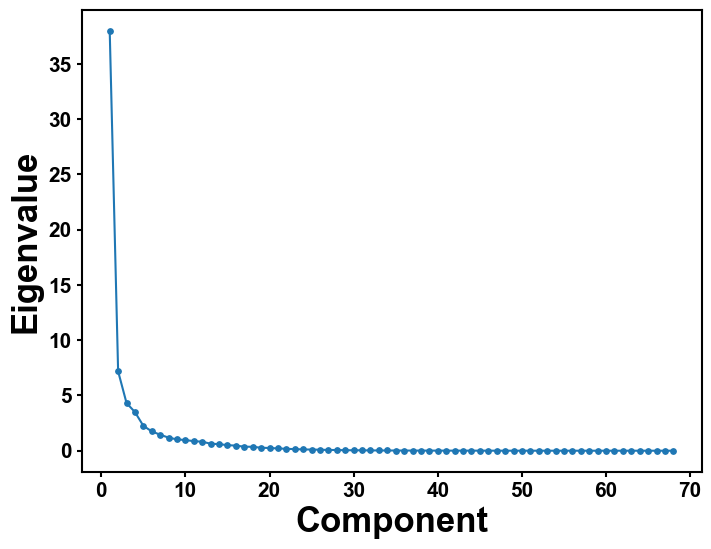

(array([24.8020503 , 18.32447407,  4.50456027,  4.42549204]), array([0.36473603, 0.26947756, 0.06624353, 0.06508077]), array([0.36473603, 0.63421359, 0.70045713, 0.76553789]))


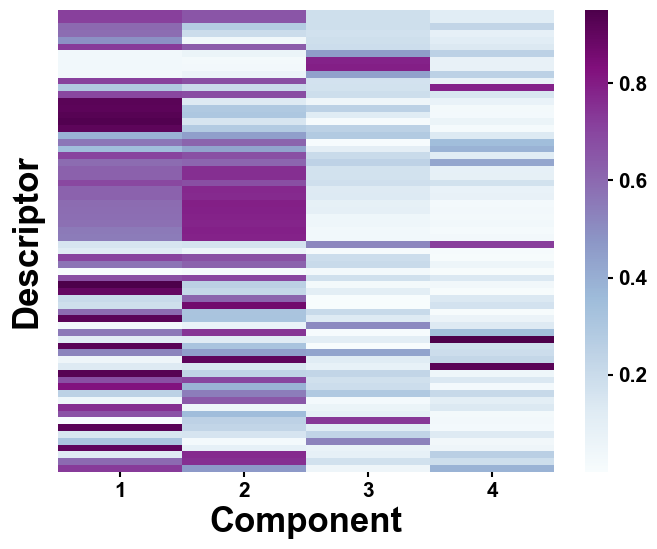

                index         1         2         3         4
NHOHCount          13  0.919711  0.127127  0.049869  0.071951
NOCount            14  0.914685  0.290396  0.252335  0.023286
NumHAcceptors      15  0.927126  0.303647  0.119894  0.022270
NumHDonors         16  0.936875  0.152699  0.013474  0.060340
NumHeteroatoms     17  0.913700  0.280966  0.250648  0.015584
PEOE_VSA1          40  0.949856  0.256220  0.026034  0.036188
PEOE_VSA10         41  0.898417  0.223164  0.105705  0.009097
PEOE_VSA7          43  0.183324  0.866368  0.000285  0.167278
SMR_VSA1           45  0.921317  0.316108  0.127053  0.065495
SMR_VSA7           48  0.109419  0.122337  0.104750  0.951513
SlogP_VSA2         49  0.918862  0.316606  0.002322  0.180814
SlogP_VSA5         51  0.051532  0.909718  0.119610  0.220314
SlogP_VSA6         52  0.129227  0.151121  0.084844  0.921355
TPSA               53  0.928960  0.237352  0.228400  0.047169
EState_VSA10       55  0.824765  0.386507  0.192849  0.020338
VSA_ESta

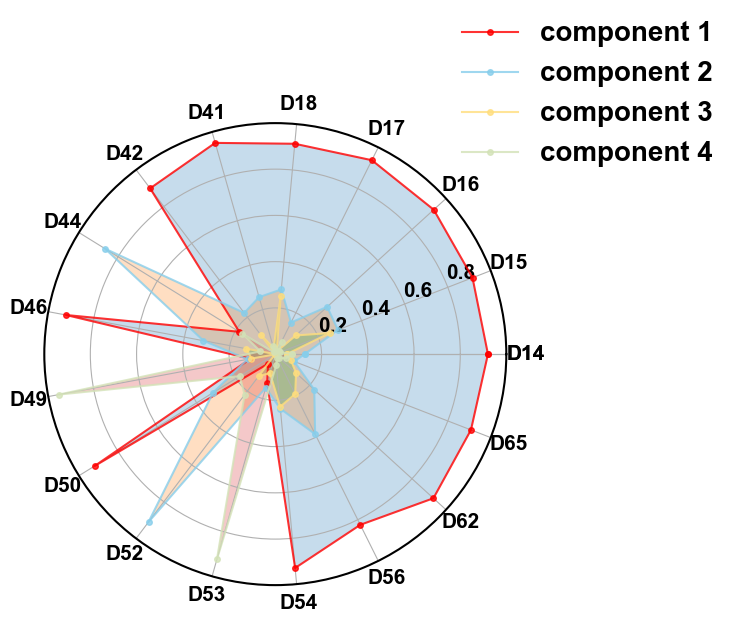

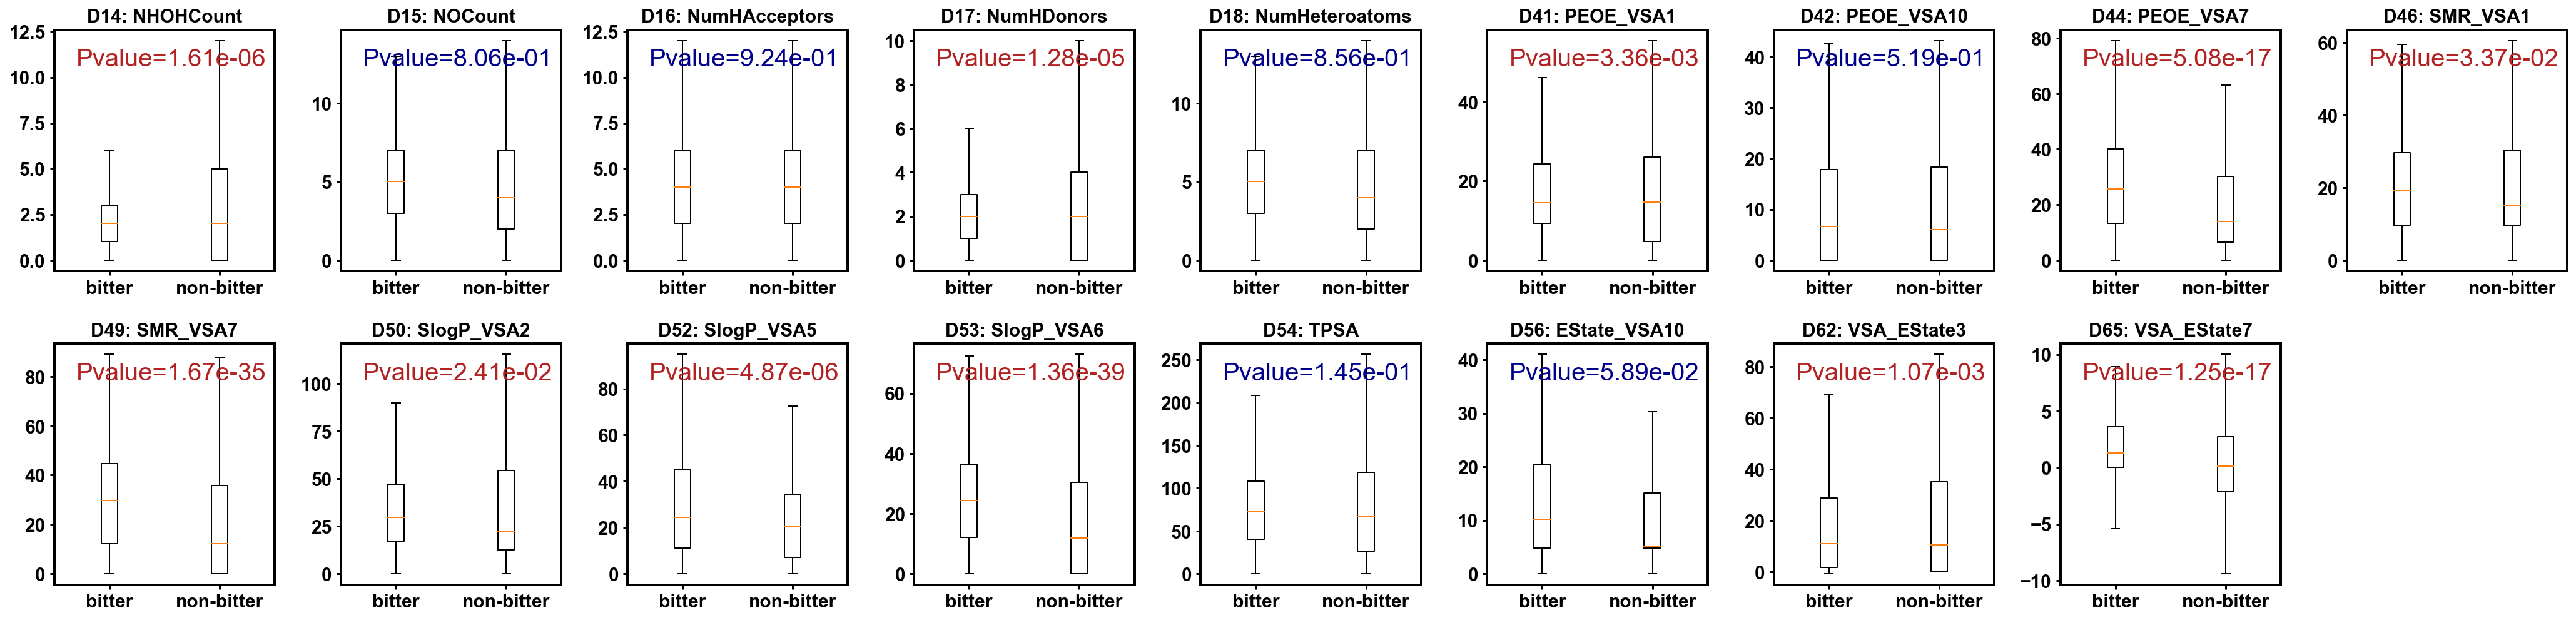

In [217]:
# bitter/non-bitter
plt.rc('xtick', labelsize= 15)
plt.rc('ytick', labelsize= 15) 
plt.rc('font',weight='black')
plt.rc('xtick.major',width=1.5)
plt.rc('ytick.major',width=1.5)
plt.rc('axes',labelweight='bold',labelsize=25, titlesize=17, titleweight='bold',linewidth=1.5)

def ev_plt(df):
    chi_square_value, p_value = calculate_bartlett_sphericity(df)
    print(chi_square_value, p_value)
    kmo_all,kmo_model=calculate_kmo(df)
    print(kmo_model)
    fa = FactorAnalyzer(df.shape[1],rotation=None)
    fa.fit(df)
    ev,v=fa.get_eigenvalues()
    plt.figure(figsize=(8,6))
    plt.scatter(range(1, df.shape[1] + 1), ev,s=15)
    plt.plot(range(1, df.shape[1] + 1), ev,markersize= 10)
    plt.xlabel("Component")
    plt.ylabel("Eigenvalue")
    plt.show()
    plt.savefig(os.path.join(base_dir,'analysis/factor/bn_brokenstone.png'))
    plt.close()

def heatmap_plt(df,num_factor):
    fa = FactorAnalyzer(num_factor,rotation="varimax")
    fa.fit(df)
    fa.get_communalities() #variable common degree
    fa.get_factor_variance() #variance, ratia varian, cumulative variance
    print(fa.get_factor_variance())
    fa.get_eigenvalues() #factor relative matrix,feature value
    df_loading = pd.DataFrame(np.abs(fa.loadings_),index=df.columns)
    df_loading.columns = [str(i) for i in range(1,num_factor+1)]
    ylabels= np.arange(1,69,1)
    plt.figure(figsize=(8,6))
    ax = sns.heatmap(df_loading, annot=False, cmap="BuPu",yticklabels=ylabels)
    ax.set(yticklabels=[])  # remove the tick labels
    ax.tick_params(left=False)
    ax.yaxis.set_tick_params(labelsize=3.5)
    plt.ylabel("Descriptor")
    plt.xlabel("Component")
    plt.show()
    plt.savefig(os.path.join(base_dir,'analysis/factor/bn_heatmap.png'))
    plt.close()
    df_loading.insert(0, 'index', range(len(df_loading)))
    df_loading = df_loading[(df_loading["1"] > 0.8)|(df_loading["2"] > 0.8)|(df_loading["3"] > 0.8)|(df_loading["4"] > 0.8)]
    return df_loading

def radar_plt(df):
    color_list = ['r','skyblue','#ffde7d','#D3E2B7']
    # legend_font = {'family': 'Arial','style': 'normal','size': 9,'weight': 'semibold',}
    values_ls = []
    for i in range(1,df.shape[1]):
        values_ls.append(list(df[str(i)]))
    feature = [f"D{i+1}" for i in list(df['index'])]
    angles=np.linspace(0, 2*np.pi,len(feature), endpoint=False)
    angles=np.concatenate((angles,[angles[0]]))
    feature = np.concatenate((feature,[feature[0]]))
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111,polar=True)
    for i,values in enumerate(values_ls):
        values=np.concatenate((values,[values[0]]))
        ax.plot(angles, values, 'o-', markersize= 4,linewidth=1.5,label='component {}'.format(i+1),c=color_list[i],alpha=0.8)
        ax.fill(angles, values, alpha=0.25)
        ax.set_thetagrids(angles * 180/np.pi, feature)
    ax.legend(bbox_to_anchor=(0.85, 0.85),frameon=False,fontsize=20)
    ax.grid(True)
    plt.savefig(os.path.join(base_dir,'analysis/factor/bn_radar.png'))
    return feature

ev_plt(bn_ft)
df_loading = heatmap_plt(bn_ft,4)
print(df_loading)
feature = radar_plt(df_loading)

print(feature)
ttest_feats = df_loading.index.values
df_bn_ft = df_ft[ttest_feats]
bn_bitters_descriptors = np.array(df_bn_ft)[bitter_idx].T
# bn_sweets_descriptors = np.array(df_bn_ft)[sweet_idx].T
bn_nonbitters_descriptors = np.array(df_bn_ft)[nonbitter_idx].T

def plot_bibox(A,B,labelA,labelB,title):
    pv = stats.ttest_ind(A,B,equal_var=True)
    if pv.pvalue < 0.05:
        color="#B22222"
    else:
        color="#00008B"
    plt.boxplot([A, B],
                showfliers=False,
                meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
                flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10},
                labels=[labelA,labelB])
    plt.title(title, fontweight="bold",fontsize = 15)     
    plt.text(0.1,0.85,"Pvalue={:.2e}".format(pv.pvalue),
             fontsize=20,
             fontweight="medium",
             color=color,
             transform=ax.transAxes)

font = {'family': 'Arial', 'size': 15, 'weight':'bold'}
err_attr = {"elinewidth":2, "ecolor":"black", "capsize":3}
plt.rc('font', **font)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('axes',labelweight='bold', titleweight='bold',linewidth=2.0)
plt.figure(figsize=(36,8), dpi=144)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3,hspace=0.3)
for i in range(17):
    ax=plt.subplot(2,9,i+1)
    plot_bibox(bn_bitters_descriptors[i],bn_nonbitters_descriptors[i],"bitter","non-bitter",'{}: {}'.format(feature[i],ttest_feats[i]))
plt.savefig(os.path.join(base_dir,'analysis/factor/bn_ttest.png'),bbox_inches="tight")
plt.show()
plt.close()



## Correalation analysis

In [49]:
out_dir = base_dir+'/analysis/energy/out_pdbqt/'
smi_path = os.path.join(base_dir, 'dataset/bitter_sweet_nonbitter/secondary_bsn.csv')
feature_path = os.path.join(base_dir, 'analysis/factor/features.csv')
df = pd.read_csv(smi_path, header=0, sep=',') 
print(df['Taste'].value_counts())
df_bitters = df.query('Taste=="Bitter"')
df_nonbitters = df.query('Taste=="Sweet"|Taste=="Non-bitter-Sweet"')
df_features = pd.read_csv(feature_path, header=0, sep=',') 
bitter_indices = df_bitters['index']
nonbitter_indices = df_nonbitters['index']
feature_names = list(df_features.columns)
energy_ls=[]
for i in range(df['smiles'].count()):
    with open(f'{out_dir}docking_out_{i}.pdbqt') as f:
        lines = f.readlines()
        words = lines[1].split()
        energy_ls.append(float(words[3]))
energy_ls = np.array(energy_ls)
# print(min(energy_ls))
# print( np.where(energy_ls == min(energy_ls)))
bitter_energys = energy_ls[bitter_indices]
nonbitter_energys = energy_ls[nonbitter_indices]
bitter_features = np.array(df_features)[bitter_indices]
print(bitter_energys.shape)
print(nonbitter_energys.shape)
print()

Sweet               1383
Bitter              1152
Non-bitter-Sweet     244
Name: Taste, dtype: int64
(1152,)
(1627,)



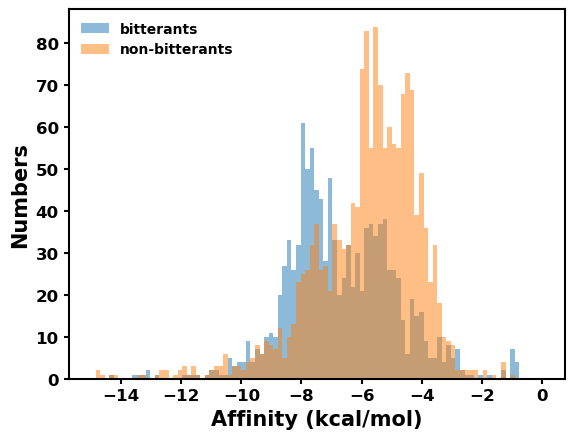

MannwhitneyuResult(statistic=646350.0, pvalue=2.9131841474870144e-44)

In [50]:
plt.rc('xtick', labelsize= 12)
plt.rc('ytick', labelsize= 12) 
plt.rc('font',weight='semibold')
plt.rc('xtick.major',width=1.5)
plt.rc('ytick.major',width=1.5)
plt.rc('axes',labelweight='semibold',labelsize=15, titlesize=17, titleweight='bold',linewidth=1.5)

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
bins = np.linspace(-15, 0, 100)
plt.hist(bitter_energys, bins, alpha = 0.5, label='bitterants')
plt.hist(nonbitter_energys, bins, alpha = 0.5, label='non-bitterants')
plt.legend(loc='upper left',frameon = False)
plt.xlabel("Affinity (kcal/mol)")
plt.ylabel("Numbers")
plt.show()

# from scipy.stats import kstest
# kstest(bitter_energys,cdf = "norm")
# kstest(nonbitter_energys,cdf = "norm")
# from scipy.stats import shapiro
# shapiro(bitter_energys) #false

import scipy.stats as stats
stats.mannwhitneyu(bitter_energys,nonbitter_energys,alternative='two-sided')



Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
5


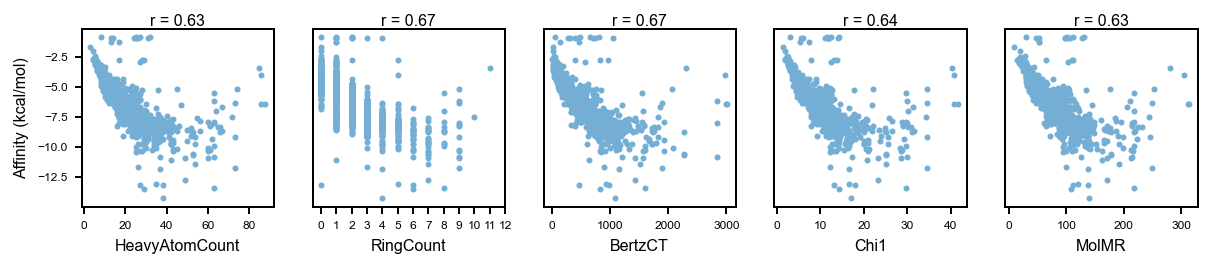

In [52]:
engs = bitter_energys
fts = bitter_features
new_fts = []
new_engs = []
for i in range(len(engs)):
    if -15<engs[i]<0:
        new_engs.append(engs[i])
        new_fts.append(fts[i])
new_fts = np.array(new_fts)
new_engs = np.array(new_engs)
feature_names

r_dic = {}
for j in range(new_fts.shape[1]):
    try:
        parameter = np.polyfit(new_fts[:,j], new_engs, 1)
        y_fit = parameter[0] * np.array(new_fts[:,j])  + parameter[1]
        correlation = np.corrcoef(new_engs, y_fit)[0,1]  
        if correlation>0.63:
            r_dic[j] = correlation
    except:
        continue
corelated_indices = list(r_dic.keys())
corelated_names = np.array(feature_names)[corelated_indices]
print(len(corelated_names))
font = {'family': 'Arial', 'size': 15, 'weight':'medium'}
plt.rc('font', **font)
plt.rc('xtick',labelsize=6)
plt.rc('ytick',labelsize=6)
plt.rc('xtick.major',width=1)
plt.rc('ytick.major',width=1)
plt.rc('axes',labelweight='medium', titleweight='medium',linewidth=1.0)
plt.figure(figsize=(10,1.6), dpi=144)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2,hspace=0.2)
for i in range(5):
    ax=plt.subplot(1,5,i+1)
    #Pearson Correlation Coefficient
    plt.title('r = {:.2f}'.format(r_dic[corelated_indices[i]]),fontsize=8,x=0.5,y=0.95)
    plt.scatter(new_fts[:,corelated_indices[i]], new_engs, s=4, c='#74AED4')
    plt.xlabel(corelated_names[i],fontsize=8)
    if i==0:
        plt.ylabel('Affinity (kcal/mol)',fontsize=8)
    else:
        plt.yticks ([])
    if i==1:
        plt.xticks(range(0,13,1))
# plt.savefig(os.path.join(base_dir,'analysis/factor/ttest.png'),bbox_inches="tight")
plt.show()
plt.close()

In [202]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 
import pandas as pd
# from gnn.ae_csn import ae_coordinates

#read molecules information
path = os.path.join(base_dir, 'dataset/bitter_sweet_nonbitter/secondary_bsn.csv' )
df = pd.read_csv(path, header=0, sep=',') 
PandasTools.AddMoleculeColumnToFrame(frame=df, smilesCol='smiles')
df_bitter =  df.query('Taste=="Bitter"')
df_sweet = df.query('Taste=="Sweet"')
df_nonbitters = df.query('Taste=="Non-bitter-Sweet"')
bitters = list(df_bitter["index"])
sweets = list(df_sweet["index"])
nonbs = list(df_nonbitters["index"])
mols = df["ROMol"]
fps = np.array([list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)) for mol in mols])
tsne = TSNE(n_components=2)
tsne_coords = tsne.fit_transform(fps)
umap_ = umap.UMAP() 
umap_coords = umap_.fit_transform(fps)
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(fps)
# ae_coords = ae_coordinates()


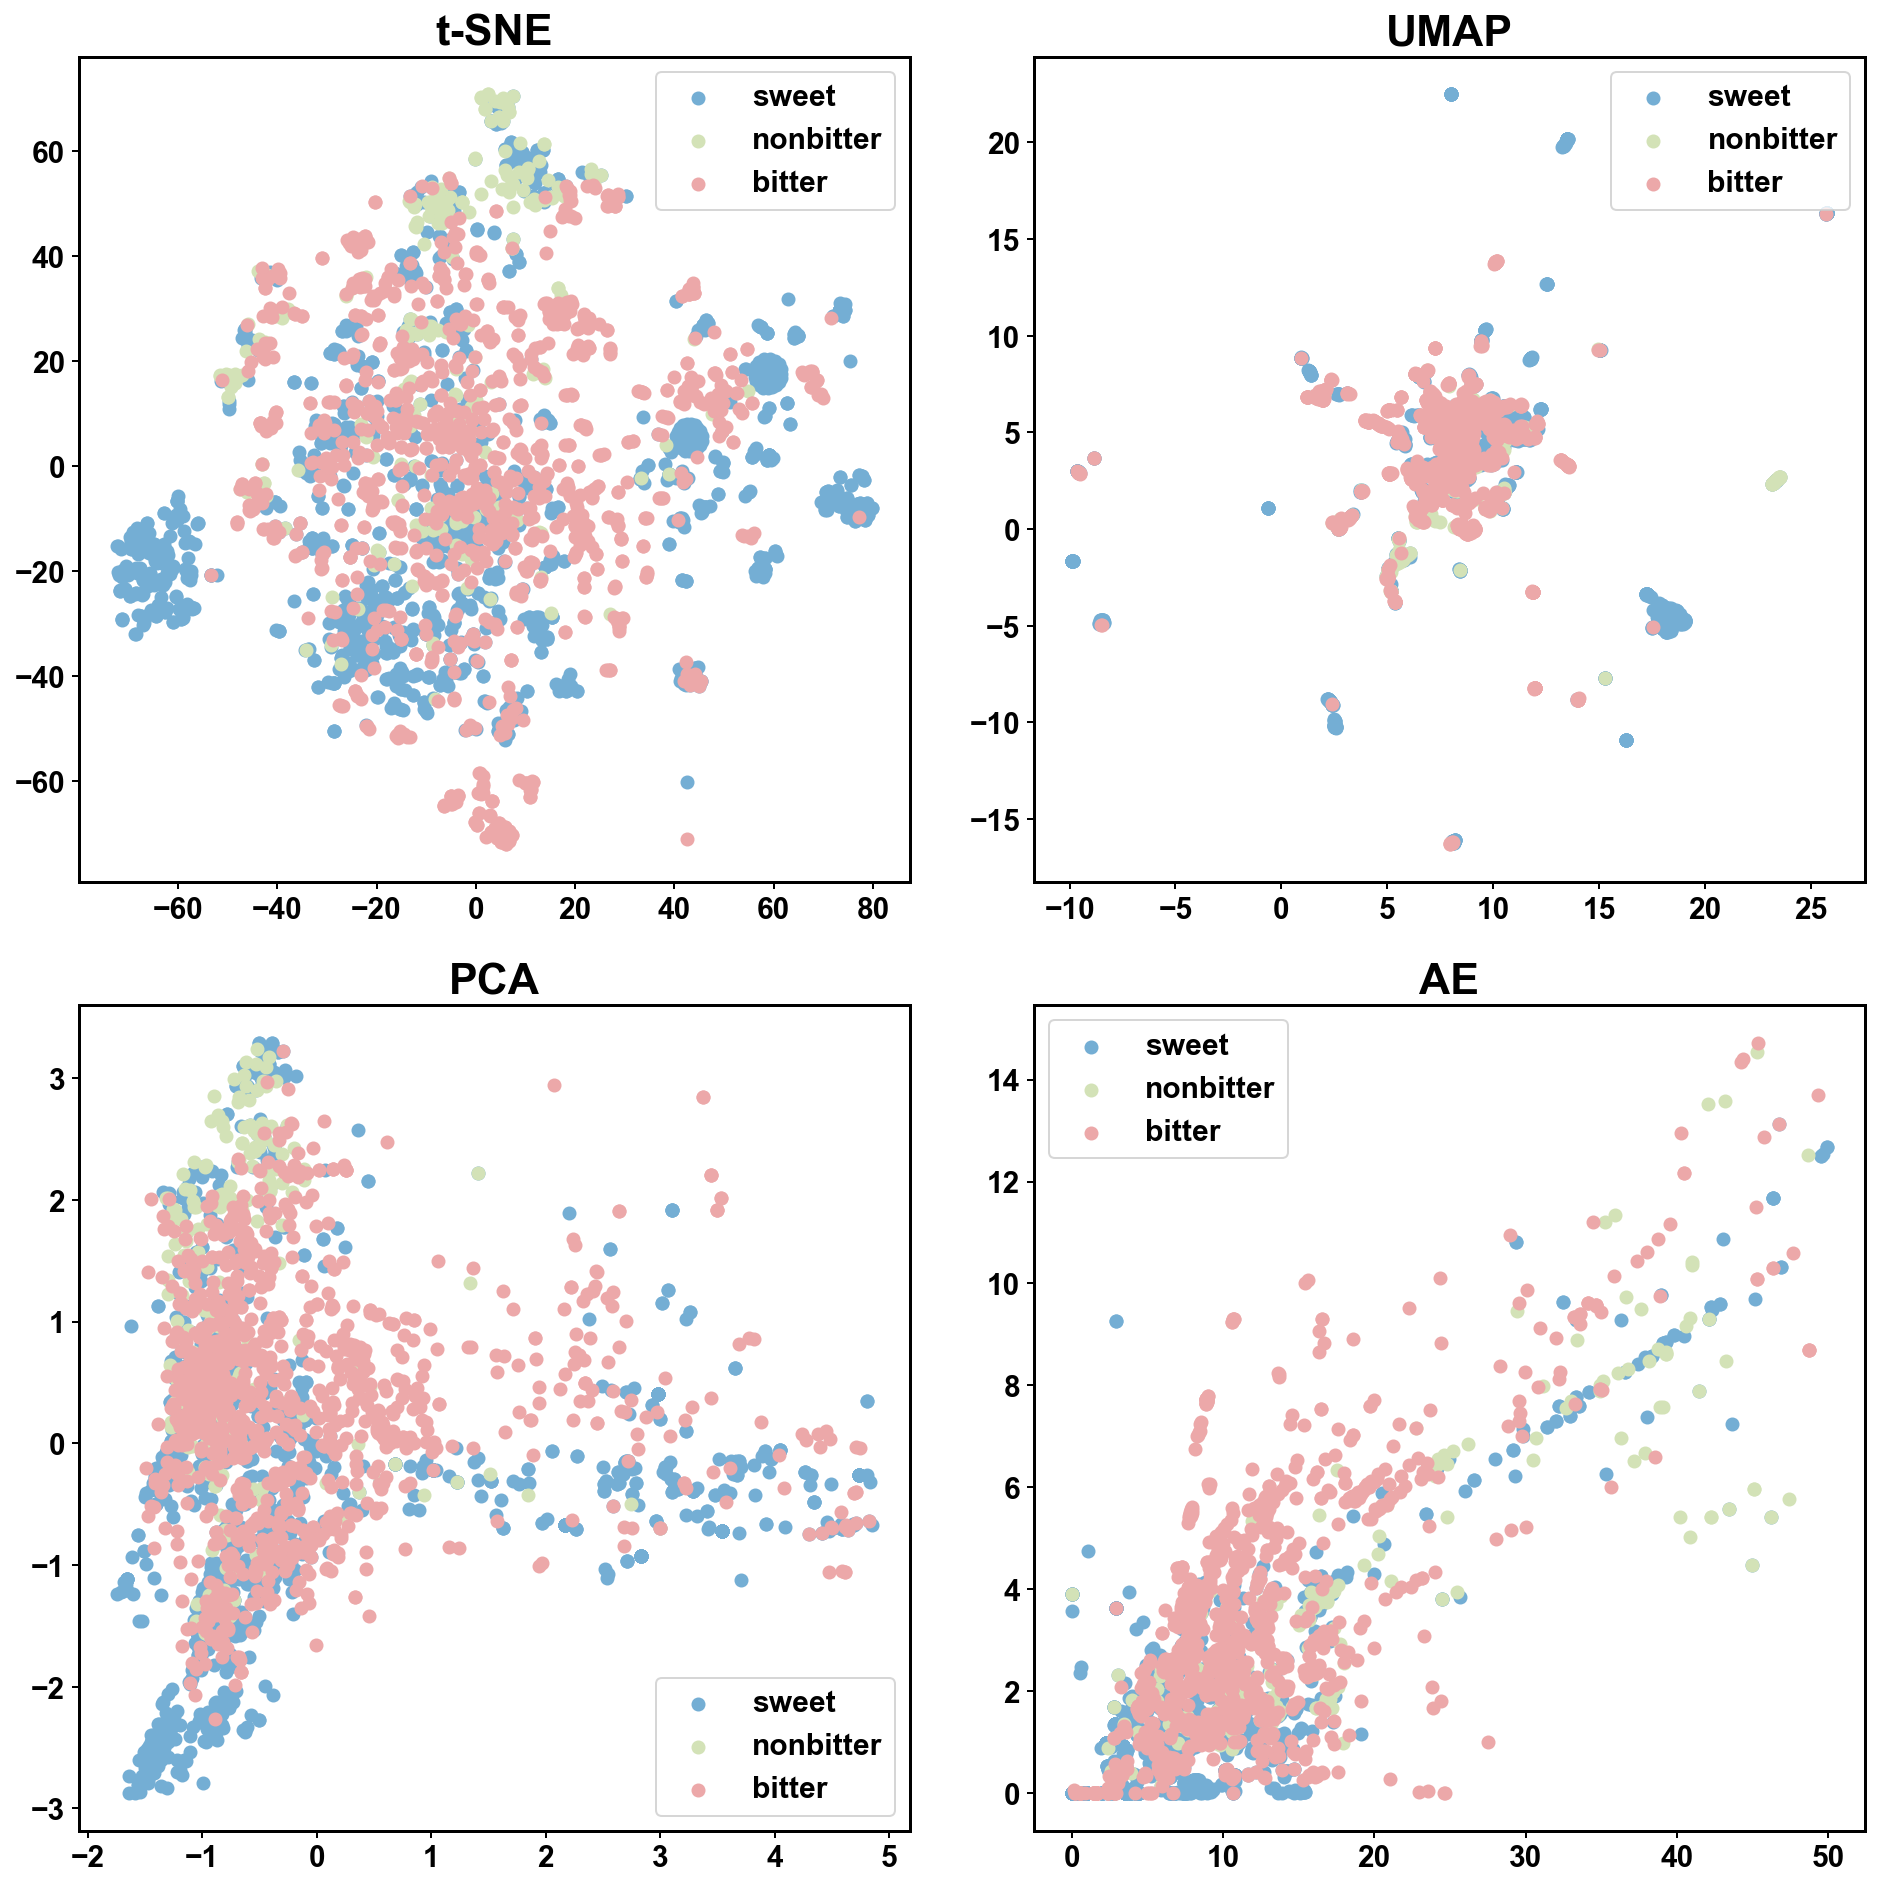

In [218]:

ae_coords = np.loadtxt('/home/hy/Documents/Project/bitterants/ae_coordinates.txt')
all_coords = [tsne_coords,umap_coords,pca_coords,ae_coords]
titles= ['t-SNE','UMAP','PCA','AE']
groups=[sweets,nonbs,bitters]
labels= ['sweet','nonbitter','bitter']
plt.figure(figsize=(16,16), dpi=144)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15,hspace=0.15)
plt.rc('axes',labelweight='bold', labelsize=1)
for i,coords in enumerate(all_coords):
    ax=plt.subplot(2,2,i+1)
    color_list = ['#74AED4', '#D3E2B7', '#ECA8A9', 'g', 'c', 'b', 'm', 'teal', 'dodgerblue','indigo', 'deeppink', 'pink', 'peru', 'brown', 'lime', 'darkorange']
    for g_idx,group in enumerate(groups):
        plt.scatter(coords[:,0][group],coords[:,1][group],color=color_list[g_idx],label = labels[g_idx])
    plt.title(titles[i],fontsize="x-large")
    plt.legend()    
